In [ ]:
# Mount Colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Setting the current working directory
import os; os.chdir('/content/drive/My Drive/Colab Notebooks/Fast Trax Data/dataset')

In [ ]:
import pandas as pd
import numpy as np

# Dependencies for Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# For reducing the number of dimensions i.e. decomposition of features
from sklearn.decomposition import PCA  

# Step 1 :Import Pickle as Dataframe

In [ ]:
# Importing Converted 2 Million Data Records

df = pd.read_pickle('converted_data_complete.pkl')

In [ ]:
relevant_features = [ 'coordinates',  'speed',  'imei', 'insertionTimeString', 'timeString', 'deltaDistance', "siteName'"]

In [ ]:
# del df
for col in df.columns:
  if col not in relevant_features:
    del df[col]

# Step 2 : Feature Engineering
---------------
## All feature engineering are explained in 'FastTrax_EDA_25GBRAM.ipynb'

### (i) Latitude , Longitude

In [ ]:
# Creating Separate Latitude and Longitude columns from 'coordinate' feature
def get_Longitude(a_list):
  return a_list[0]

def get_Latitude(a_list):
  return a_list[1]

df['Longitude'] = df['coordinates'].apply(get_Longitude)
df['Latitude'] = df['coordinates'].apply(get_Latitude)

del df['coordinates']

### (ii). Time Difference Values

In [ ]:
df['insertionTimeString'] = pd.to_datetime(df['insertionTimeString'])
df['timeString'] = pd.to_datetime(df['timeString'])
df['time_difference_days'] = (df['insertionTimeString'] - df['timeString']).astype('timedelta64[D]')
df['time_difference_hours'] = (df['insertionTimeString'] - df['timeString']).astype('timedelta64[h]')
df['time_difference_minutes'] = (df['insertionTimeString'] - df['timeString']).astype('timedelta64[m]')
df['time_difference_secs'] = (df['insertionTimeString'] - df['timeString'])/np.timedelta64(1,'s')

## (iii). Creating a List of Overspeeding imei

In [ ]:
# Creating a list for IMEI numbers who are overspeeding above 80 Kmph
overspeedings = df.loc[df['speed'] >= 80, 'imei'].unique().tolist()
len(overspeedings)

94

# Step 3 : Data to be Consedered for Clustering the riders:
### (i)  . Create a feature Overspeeding : (Yes or No)
### (ii) . Speed - Normalize the Values
### (iii). Time Difference (time_difference_days, time_difference_hours, time_difference_minutes, time_difference_secs)
### (iv) . siteName (Create Dummy Variables)
### (v).  deltaDistance (Give us a idea about average speed) - Normalize values <br>
--------------------

### (i). Creating 'Oversped' feature for determining if overspeeding(1) or not(0)

In [ ]:
# Create 'Oversped' column with null values
df['Oversped'] = 0

In [ ]:
# Function to assign 1 value if corresponding speed is > 80 Kmph
def create_overspeeding(speed_val):
  if speed_val >= 80:
    return 1

In [ ]:
# Creating 'Oversped'
df['Oversped'] = df['speed'].apply(create_overspeeding)
df['Oversped'].fillna(0, inplace=True)

In [ ]:
# checking count of speeding vs non-speeding
df['Oversped'].value_counts()

0.0    6569189
1.0       3147
Name: Oversped, dtype: int64

### (ii) . Creating a small dataframe for Clustering consisting of relevant features only

In [ ]:
cluster_relevant_features = ['imei', 
                             'speed', 
                             'time_difference_days','time_difference_hours', 'time_difference_minutes','time_difference_secs', 
                             'Oversped',
                             "siteName'",
                             "deltaDistance"]

In [ ]:
# Creating a sub dataframe for clustering
cluster_calc_df = df[cluster_relevant_features]

In [ ]:
# Dropping all datapoints with null/missing siteName
cluster_calc_df = cluster_calc_df[cluster_calc_df["siteName'"] != ""]

In [ ]:
# Resetting Index after removing some rows
cluster_calc_df.reset_index(drop=True, inplace=True)

In [ ]:
# Rechecking for any remaining null siteName
len(cluster_calc_df[cluster_calc_df["siteName'"] == ""])

0

### (iii). Creating dummy variables on "siteName'" feature as it is catagorical value

In [ ]:
cluster_calc_df.shape

(6045170, 9)

In [ ]:
cluster_calc_df = pd.concat([cluster_calc_df.drop("siteName'", axis=1), 
                             pd.get_dummies(cluster_calc_df["siteName'"])], axis=1)

In [ ]:
cluster_calc_df.head(10)

,imei,speed,time_difference_days,time_difference_hours,time_difference_minutes,time_difference_secs,Oversped,deltaDistance,Chennai,Maersk Bangalore,Mumbai,Pune
0,356306056969307,10.0,0.0,0.0,0.0,1.0,0.0,0.057193,0,0,0,1
1,868728032008770,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0
2,868728030767575,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0
3,868728039207045,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0
4,868728030809427,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0,0
5,353612088569350,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,1,0,0,0
6,356306056165153,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,0,0,0,1
7,356306054815734,0.2,0.0,0.0,0.0,1.0,0.0,0.000000,0,0,0,1
8,353612087227729,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1
9,353612088021931,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,0,0,0


### (iv). Normalizing all the features to bring them in same scaler of 0 to 1.

In [ ]:
from sklearn import preprocessing

cluster_calc_df_scaled = cluster_calc_df
X =  preprocessing.scale(cluster_calc_df_scaled.drop('imei', axis=1)) #X_train

# Creating KMeans Clustering Classifier

In [ ]:
kmeans = KMeans( n_clusters= 7)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
clustering_labels = kmeans.fit_predict(X)

In [ ]:
cluster_calc_df["clustering_labels"] = clustering_labels
cluster_calc_df_scaled["clustering_labels"] = clustering_labels

In [ ]:
cluster_calc_df["clustering_labels"].value_counts()

3    3170734
0    1514700
2    1108178
4     211896
1      37240
5       2420
6          2
Name: clustering_labels, dtype: int64

In [ ]:
# Cluster 5 Category of Vehicles/Drivers have no transactions/commute. 
cluster_calc_df[cluster_calc_df['clustering_labels'] == 5]['speed'].mean()

84.4301652892562

## NOTE : Cluster_label = 5, Vehicles/Drivers have zero average speed  and hence represents no commute. It is a wastage of organisational resource and should be appropriately treated/shunted. 
-------------------

In [ ]:
# Cluster 2 Category of Vehicles/Drivers have very poor speed. 
cluster_calc_df[cluster_calc_df['clustering_labels'] == 2]['speed'].mean()

12.383208654203802

## NOTE : Cluster_label = 2, Vehicles/Drivers have a vely low average speed  and hence can be a indicator of suboptimal driving/poor route taken/peak hours. 
-------------------

In [ ]:
# Cluster 4Category of Vehicles/Drivers have a average speed of more than 80Kmph and hence can be evaluated. 
cluster_calc_df[cluster_calc_df['clustering_labels'] == 4]['speed'].mean()

5.5649139200362265

In [ ]:
# List of IMEI who are rash/overspeed driving
rash_driving_imei_list = cluster_calc_df[cluster_calc_df['clustering_labels'] == 4]['imei'].unique().tolist()
rash_driving_imei_list

['352353085225297',
 '352353085217898',
 '352353085222732',
 '356306056061600',
 '356306056091169',
 '352353085231550',
 '356306056981708',
 '356306056914139']

## NOTE : Cluster_label = 4, Vehicles/Drivers have a average speed of more than 80Kmph and hence can be a indicator of rash driving.
------------------

# Visualization of Cluster <br>
---------------
### Our data has much higher dimensions i.e. 11 which is not possible to be visualized. <br>
### Hence we will use PCA decomposition to reduce the number of features/dimensions to 3.
### The these 3 Features can be visualized in a comprehensive manner
----------------
### NOTE : Here we will be only taking subset of data with 10 Million records, so that we can manage the memory and avoid any overflow/error

In [ ]:
cluster_calc_df.head()

,imei,speed,time_difference_days,time_difference_hours,time_difference_minutes,time_difference_secs,Oversped,deltaDistance,Chennai,Maersk Bangalore,Mumbai,Pune,clustering_labels
0,356306056969307,10.0,0.0,0.0,0.0,1.0,0.0,0.057193,0,0,0,1,3
1,868728032008770,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0,0
2,868728030767575,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0,0
3,868728039207045,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0,0
4,868728030809427,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0,0,0


In [ ]:
cluster_calc_df.shape

(6045170, 13)

In [ ]:
sub_df = (cluster_calc_df.drop(['imei'], axis=1))

In [ ]:
sub_df = sub_df.head(1000000)

In [ ]:
sub_df.shape

(1000000, 12)

In [ ]:
pca = PCA(3) 

pca.fit(sub_df) 

pca_data = pd.DataFrame(pca.transform(sub_df)) 

print(pca_data.head())


              0         1         2
0 -44466.103375  0.850174  1.026694
1 -44465.103489 -9.143586 -2.303596
2 -44465.103489 -9.143586 -2.303596
3 -44465.103489 -9.143586 -2.303596
4 -44466.103350 -9.143599 -2.303965


In [ ]:
from matplotlib import colors as mcolors 
import math 

''' Generating different colors in ascending order 
								of their hsv values '''
colors = list(zip(*sorted(( 
					tuple(mcolors.rgb_to_hsv( 
						mcolors.to_rgba(color)[:3])), name) 
					for name, color in dict( 
							mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
													).items())))[1] 


# number of steps to taken generate n(clusters) colors 
skips = math.floor(len(colors[5 : -5])/7) 
cluster_colors = colors[5 : -5 : skips]


In [ ]:
kmeans.labels_ = kmeans.labels_[:1000000]

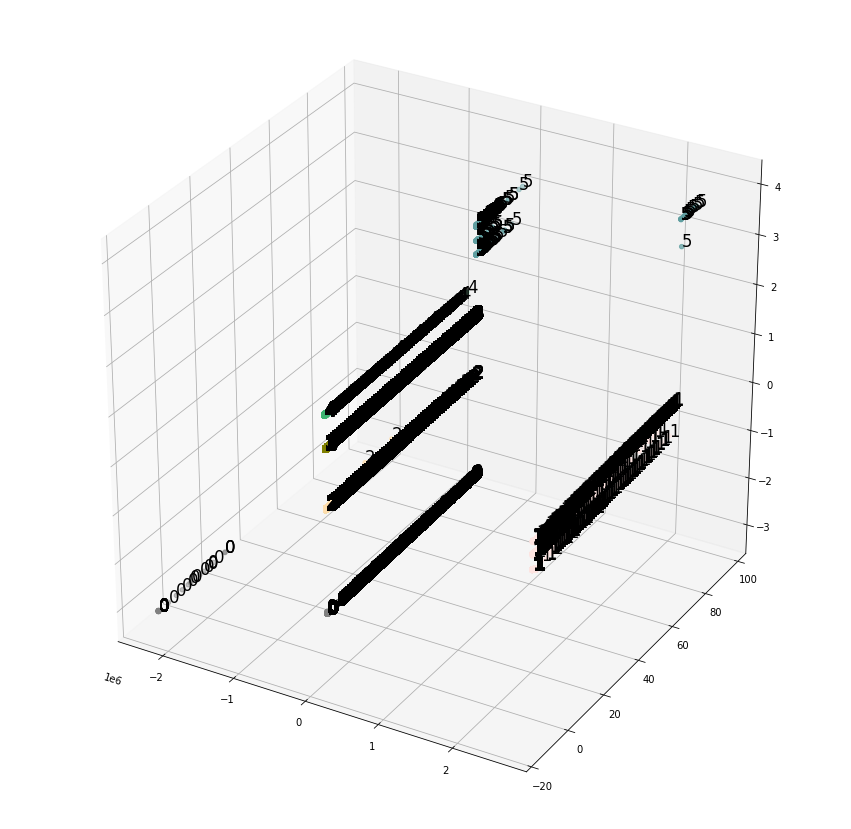

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(15,15)) 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 

str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 

list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

plt.savefig("7_Cluster_10_Lakh_Datapoints1.png")   
plt.show()


In [ ]:
sub_df

,speed,time_difference_days,time_difference_hours,time_difference_minutes,time_difference_secs,Oversped,deltaDistance,Chennai,Maersk Bangalore,Mumbai,Pune,clustering_labels
0,10.0,0.0,0.0,0.0,1.0,0.0,0.057193,0,0,0,1,3
1,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0,0
2,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0,0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0,1,0,0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9.0,0.0,0.0,0.0,1.0,0.0,0.023842,0,0,0,1,3
999996,7.0,0.0,0.0,0.0,0.0,0.0,0.039782,1,0,0,0,2
999997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,3
999998,1.0,0.0,0.0,0.0,2.0,0.0,0.000000,1,0,0,0,2
